---
# <center>**Projet Geoloc**</center>
---

## **Groupe :**
* *Philippe Bénézeth*
* *Xavier Bracquart*
* *Thomas Koch*
* *Nicolas Louis*
---

## **Objectifs :**
* Construire la matrice des features
* Construire la vérité terrain
* Tracer la probabilité d'erreur cumulative
* Calculer le critère de prédiction avec l'erreur à 80%
* Extraire la prédiction sur les données de test
* Enregistrer le résultat dans un fichier `.csv`
* Utiliser une validation croisée avec une stratégie de « leave 1 device out »
---

What kind of ML problems do we have ?
> On est sur un problème de régression.

What is the feature matrix / Ground truth ?
> Voir slide 34 du cours.

What kind of algorithm will we use ?
> Plusieurs alogorithmes du type supervisés sont possibles.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

#pd.set_option('display.max_columns', 300)

---
## **1. Exploration des données**
### 1.1 Chargement des données

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

### 1.2 Visualisation des différents dataframe obtenus

In [3]:
# Training set
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [5]:
# Testing set
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [6]:
df_mess_test.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,29286.000000,29286.00000,29286.000000,29286.000000,2.928600e+04,29286.000000,29286.000000
mean,4643.290651,411306.93263,1.043075,-125.742454,1.472354e+12,42.332918,-101.228888
std,2578.625841,134472.75089,0.611285,8.861454,5.101975e+09,7.517469,11.198741
min,1012.000000,110335.00000,0.000000,-151.000000,1.463542e+12,36.528704,-110.957181
25%,2846.000000,472397.00000,1.000000,-132.000000,1.468001e+12,39.734330,-105.077530
50%,3563.000000,472504.00000,1.000000,-127.000000,1.472920e+12,39.777690,-105.045347
75%,7456.000000,472533.00000,1.500000,-121.000000,1.476688e+12,39.807916,-105.008827
max,11007.000000,473287.00000,2.000000,-63.000000,1.481142e+12,64.300000,-68.500000


In [7]:
# Label set
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [8]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


> Pour simplifier la visualisation et la création de notre matrice de features, nous associons l'actuelle table des features à celle des positions

In [9]:
# On commence par joindre la table des features à celle des positions
df_mess_train[['pos_lat', 'pos_lng']] = pos_train

In [10]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


In [11]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289


### 1.3 Valeurs uniques
> Repérons le nombre de valeurs uniques pour les 6 premières colonnes de notre `df_mess_train`. On utilise pour cela la méthode `.nunique` de `pandas`.

In [12]:
print("Nombre de messages uniques : %d" %(df_mess_train.messid.nunique()))
print("Nombre de stations uniques : %d" %(df_mess_train.bsid.nunique()))
print("Nombre de devices uniques : %d" %(df_mess_train.did.nunique()))
print("Nombre de valeurs uniques dans time_ux : %d" %(df_mess_train.time_ux.nunique()))
print("Nombre de valeurs uniques de rssi : %d" %(df_mess_train.rssi.nunique()))
print("Nombre de valeurs uniques de nseq: %d" %(df_mess_train.nseq.nunique()))

Nombre de messages uniques : 6068
Nombre de stations uniques : 251
Nombre de devices uniques : 113
Nombre de valeurs uniques dans time_ux : 6067
Nombre de valeurs uniques de rssi : 276
Nombre de valeurs uniques de nseq: 5


### 1.4 Distribution des valeurs pour les différentes variables
> Intéressons-nous ici à la distribution des valeurs pour certaines variables de notre jeu d'entraînement et celui de validation.

#### `nseq`

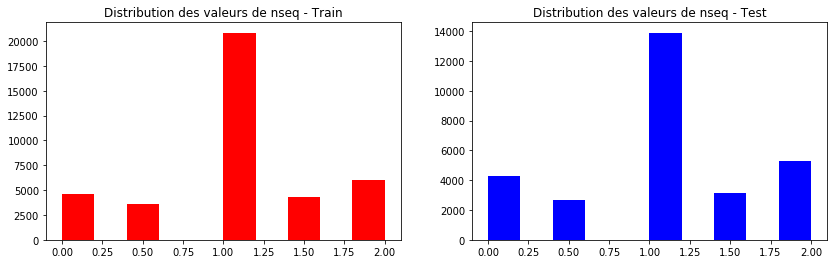

In [13]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(df_mess_train.nseq, color='red')
plt.title("Distribution des valeurs de nseq - Train \n")
plt.subplot(122)
plt.hist(df_mess_test.nseq, color='blue')
plt.title("Distribution des valeurs de nseq - Test \n")
plt.show()

> Nous avons donc ici des valeurs catégorielles avec une distribution assez similaire entre le jeu d'entraînement et celui de test.

#### `rssi`

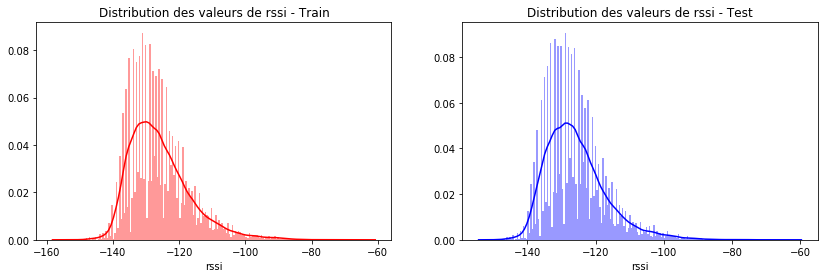

In [14]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.rssi, bins=200, color='red')
plt.title("Distribution des valeurs de rssi - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.rssi, bins=200, color='blue')
plt.title("Distribution des valeurs de rssi - Test \n")
plt.show()

> Là encore, la distribution semble équivalente entre le jeu d'entraînement et celui de test. 

#### `time_ux`

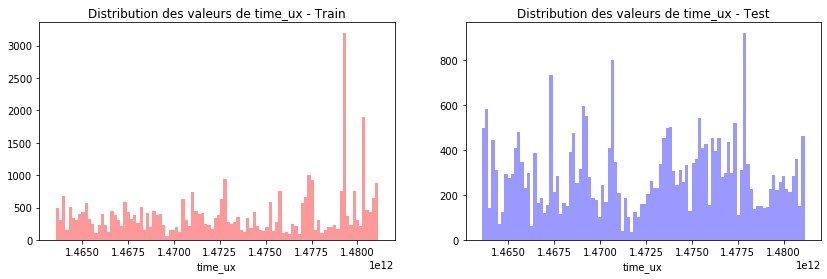

In [15]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.time_ux, bins=100, kde=False, color='red')
plt.title("Distribution des valeurs de time_ux - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.time_ux, bins=100, kde=False, color='blue')
plt.title("Distribution des valeurs de time_ux - Test \n")
plt.show()

> Les distributions sont ici différentes mais toutes deux comprises entre 1.4625 ms et 1.4825 ms.

#### `bsid`

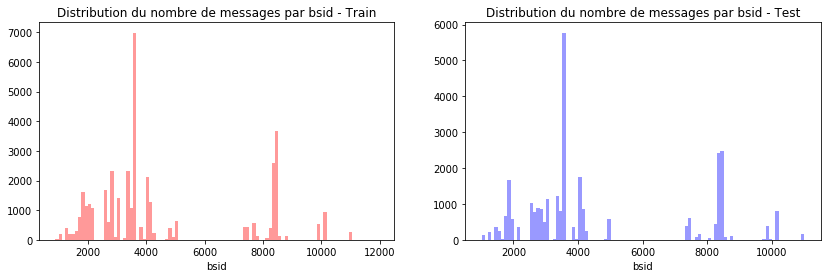

In [16]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.bsid, bins=100, kde=False, color='red')
plt.title("Distribution du nombre de messages par bsid - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.bsid, bins=100, kde=False, color='blue')
plt.title("Distribution du nombre de messages par bsid - Test \n")
plt.show()

> Il est ici à noter que certaines stations recoivent beaucoup plus de messages que d'autres. Cela sera donc à prendre en compte lors de l'analyse des catégories peu représentées. La distribution est en revanche similaire entre le jeu d'entraînement et celui de test.

#### `did`

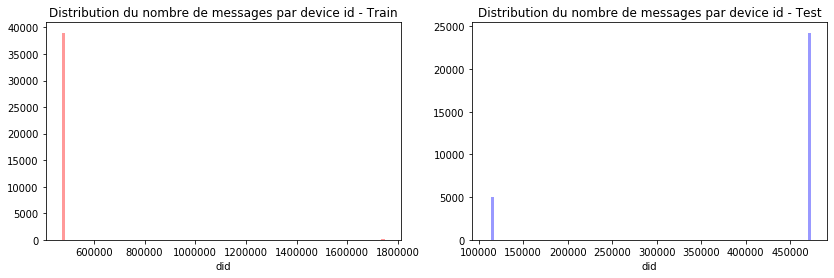

In [17]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.did, bins=100, kde=False, color='red')
plt.title("Distribution du nombre de messages par device id - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.did, bins=100, kde=False, color='blue')
plt.title("Distribution du nombre de messages par device id - Test \n")
plt.show()

> Il faut ici noter que les valeurs des id de devices sont très différentes. Il faudra donc regarder le nombre de messages par device_id et analyser les device_id peu représentés.

### 1.5 Corrélation entre variables
> Analysons ici les corrélations entre variables

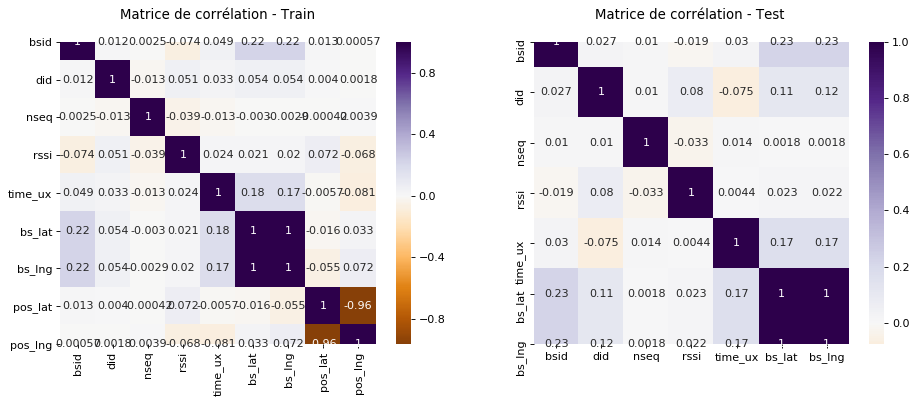

In [28]:
plt.figure(figsize=(14,5), dpi=80)
plt.subplot(121)
sns.heatmap(df_mess_train.corr(), cmap='PuOr', center=0, annot=True)
plt.title('Matrice de corrélation - Train\n', fontsize=12)
plt.subplot(122)
sns.heatmap(df_mess_test.corr(), cmap='PuOr', center=0, annot=True)
plt.title('Matrice de corrélation - Test \n', fontsize=12)
plt.show()

> On note donc qu'il n'y a pas de corrélations significatives entre variables, hormis entre la longitude et la lattitude des stations, mais cela était prévisible.

### 1.6 Détection de valeurs aberrantes
> Intéressons-nous ici aux valeurs aberrantes aussi nommées les *outliers*.

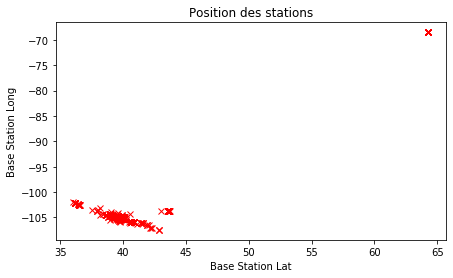

In [31]:
plt.figure(figsize=(7,4))
plt.plot(df_mess_train['bs_lat'], df_mess_train['bs_lng'], 'x', color='red')
plt.title('Position des stations pour le jeu d\'entraînement \n')
plt.xlabel('Base Station Lat')
plt.ylabel('Base Station Long')
plt.show()

> On constate donc ici que des stations sont éloignées des autres. Ces stations se trouvent à une longitude de -70 et une lattitude de 65. Voyons si cela se révèle aussi dans le jeu de test.

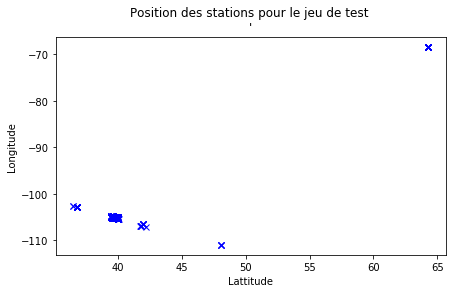

In [33]:
plt.figure(figsize=(7,4))
plt.plot(df_mess_test['bs_lat'], df_mess_test['bs_lng'], 'x', color='blue')
plt.title("Position des stations pour le jeu de test \n'")
plt.xlabel("Lattitude")
plt.ylabel("Longitude")
plt.show()

> On constate que les stations isolées se trouvent également dans le jeu de test. Voyons toutefois si des messages semblent bien avoir été émis depuis des longitudes et lattitudes similaires.

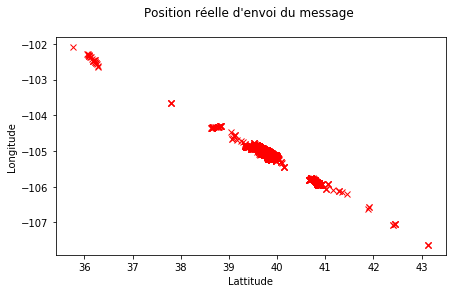

In [34]:
plt.figure(figsize=(7,4))
plt.plot(df_mess_train.pos_lat, df_mess_train.pos_lng, "x", color='red')
plt.title("Position réelle d'envoi du message \n")
plt.xlabel("Lattitude")
plt.ylabel("Longitude")
plt.show()

> Il est donc ici clair qu'aucun message n'a été envoyé à des longitudes et lattitudes prochent de -70 et 65. En conséquence, nous en déduisons que les lattitudes et longitudes de ces stations sont erronnées et il convient de définir d'une stratégie pour traiter ces anomalies. 

> Voyons donc si le nombre de messages associé à ces stations est important.

In [38]:
# Base station ayant une latitude > 60
df_mess_train[df_mess_train['bs_lat']>60]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
5106,57617e1ef0fe6e0c9fd6eb06,8355,476606.0,1.5,-106.5,1.466007e+12,64.3,-68.5,39.778694,-104.977050
5118,576180cf3e952e04b3b41e5c,8355,476512.0,0.5,-111.5,1.466008e+12,64.3,-68.5,39.783396,-104.999821
5179,5761a161f0fe6e0c9fec42b9,8355,473683.0,0.0,-126.0,1.466016e+12,64.3,-68.5,39.803407,-105.019300
5216,57623817864fce5689ec33af,8355,473683.0,0.5,-127.0,1.466055e+12,64.3,-68.5,39.803738,-105.018997
5416,5763734c864fce5689a422f3,8355,476600.0,1.5,-123.0,1.466135e+12,64.3,-68.5,39.803101,-105.023292
...,...,...,...,...,...,...,...,...,...,...
39237,58485bd412f14360d78bebdb,4987,476207.0,1.5,-130.5,1.481137e+12,64.3,-68.5,39.778872,-105.019285
39238,58485bd412f14360d78bebdb,4993,476207.0,0.0,-132.0,1.481137e+12,64.3,-68.5,39.778872,-105.019285
39241,58485bd412f14360d78bebdb,10151,476207.0,1.0,-122.0,1.481137e+12,64.3,-68.5,39.778872,-105.019285
39242,58485bd412f14360d78bebdb,11007,476207.0,1.0,-121.0,1.481137e+12,64.3,-68.5,39.778872,-105.019285


In [37]:
# Base station ayant une latitude > 60
df_mess_train[df_mess_train['bs_lat']>60].describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
count,4389.000000,4.389000e+03,4389.000000,4389.000000,4.389000e+03,4.389000e+03,4389.0,4389.000000,4389.000000
mean,6144.622465,4.986286e+05,1.038847,-125.300828,1.476081e+12,6.430000e+01,-68.5,39.759422,-105.029877
std,3451.227827,1.690960e+05,0.601033,9.230369,4.015779e+09,5.272828e-12,0.0,0.072178,0.051676
min,1092.000000,4.732880e+05,0.000000,-142.000000,1.466007e+12,6.430000e+01,-68.5,39.537137,-107.066221
25%,2707.000000,4.741810e+05,1.000000,-132.000000,1.472799e+12,6.430000e+01,-68.5,39.707218,-105.047845
50%,4993.000000,4.763150e+05,1.000000,-127.000000,1.477406e+12,6.430000e+01,-68.5,39.773364,-105.028769
75%,10151.000000,4.768290e+05,1.500000,-120.500000,1.479316e+12,6.430000e+01,-68.5,39.792541,-105.018591
max,11951.000000,1.747448e+06,2.000000,-69.333333,1.481140e+12,6.430000e+01,-68.5,42.452279,-104.921795


In [39]:
list_bs_outliers = df_mess_train[df_mess_train['bs_lat']>60].bsid.unique()
list_bs_outliers

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  2293,
        4959, 10999,  1661,  8449,  4156,  4129,  1743,  4987,  1772,
        1796,  2707,  2943,  4123, 11951,  9784,  1092,  1854,  7248])

In [48]:
print('Nombre de message associé au bsid :\n', 
      df_mess_train[df_mess_train['bs_lat']>60].groupby('bsid').count()['messid']
      .sort_values(ascending=True))

print("\nNombre de message total associé aux bsid dont bs_lat > 60 : {} "
      .format(df_mess_train[df_mess_train['bs_lat']>60].groupby('bsid').count()['messid'].sum()))

Nombre de message associé au bsid :
 bsid
4959       1
10999      1
9784       1
4123       1
11951      1
2293       2
7248       9
1854      27
1092      32
8449      72
2943      90
8560     116
1772     121
4156     127
4987     147
1661     160
1743     169
2707     191
8451     193
4129     216
1796     249
11007    275
1594     290
10151    333
8355     480
4993     488
10162    597
Name: messid, dtype: int64

Nombre de message total associé aux bsid dont bs_lat > 60 : 4389 


> On a donc identifié les stations de bases (au nombre de 27) qui ont une position très suspectes par rapport aux autres stations. De plus, nous savons maintenant combien de messages sont associés à chacune de ces stations. Le nombre total de messages pour toutes les stations est assez significatif, environ 4 000 sur 39 000 au total, soit approximativement 10\%. Toutefois, ne sachant comment les traiter autrement qu'en les supprimant puisque nous ne pouvons pas trouver facilement la position exacte de ces stations, **nous décidons de les supprimer** malgré tout. Ceci nous permettra d'éviter d'induire en erreur notre algorithme et donc de fausser les prédicitons.

In [49]:
# On retire les données liées aux stations ayant une latitude > 60
index_to_remove1 = df_mess_train[df_mess_train['bs_lat']>60].index.values
df_mess_train = df_mess_train.drop(index_to_remove1)

### 1.7 Détection des classes peu représentées
> On va ici essayer de trouver les stations qui traitent peu de messages pour potentiellement les enlever du jeu d'entraînement afin de ne garder que les stations les plus représentatives et donc d'avoir les catégories les plus fiables pour réaliser des prédicitions.

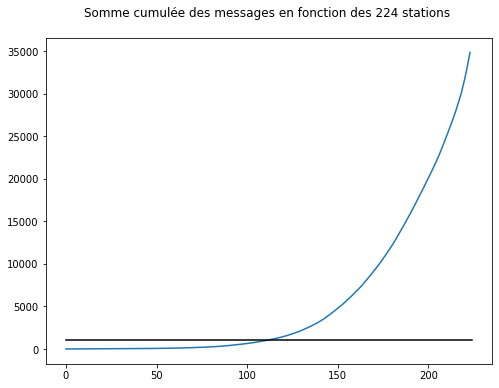

In [67]:
# On repère les base stations qui ne reçoivent pas beaucoup de messages
count_basestation = df_mess_train.groupby('bsid').count()
count_basestation = count_basestation['messid']
mes_limit = 1000 # limite en dessous de laquelle nous estimons les stations comme peu représentatives

plt.figure(figsize=(8,6))
count_basestation_cum = count_basestation.sort_values(ascending=True).cumsum()
plt.plot(count_basestation_cum.values)

x = [0, count_basestation_cum.count()]
y = [mes_limit, mes_limit]
plt.plot(x, y, color ='black')
plt.title("Somme cumulée des messages en fonction des {} stations \n".format(df_mess_train.bsid.nunique()), size=12)
plt.show()

In [92]:
print("Nombre de stations en dessous de la droite noire : {}".format((count_basestation_cum < mes_limit).sum()))

Nombre de stations en dessous de la droite noire : 111


> On constate donc qu'il y a 111 stations qui recoivent peu de messages mais qu'ensuite, les autres en recoivent significativement plus. **Nous décidons donc de retirer les stations recevant peu de messages des features qui seront utilisées pour entraîner notre modèle.**

In [97]:
# Les bsid qui ne reçoivent pas beaucoup de messages sont retirés des données d'entraînement
bsid_to_remove = count_basestation_cum[count_basestation_cum < mes_limit].index.values
index_to_remove2 = df_mess_train[df_mess_train.bsid.isin(bsid_to_remove)].index.values
df_mess_train = df_mess_train.drop(index_to_remove2)

In [98]:
# Réinitialisation des index pour faciliter les jointures des dataframes par la suite
n_train = df_mess_train.shape[0]
df_mess_train = df_mess_train.set_index(np.arange(n_train))

---
## **2. Features engineering**

--- 
## **3. Modèles de prédiction**

---
## **4. Construction du fichier de prédiction**

---
## **5. Construction d'un prédicteur avec en *leave one device out***

----
# ***Code initialement produit***

In [9]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [10]:
len(listOfBs)

259

In [13]:
df_essai = df_mess_train.groupby(['messid'], as_index=False)
df_essai.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,476257.0,1.0,-128.000000,1.481140e+12,39.777690,-105.002424
39246,5848672e12f14360d7942374,8352,476257.0,0.0,-121.000000,1.481140e+12,39.761633,-105.025753
39247,5848672e12f14360d7942374,8397,476257.0,2.0,-126.000000,1.481140e+12,39.759396,-105.001415
39248,58487473e541cd0e133cca72,3051,476593.0,1.0,-131.333333,1.481143e+12,39.898872,-105.153832


In [14]:
df_mess_train.shape

(39250, 8)

In [40]:
nb_mess = df_mess_train['messid'].nunique()
nb_mess

6068

In [37]:
df_mess_train.isnull().sum(axis = 0) #On regarde les NaN du df

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

In [72]:
i=0
for key, elmt in df_essai:
    while i < 3 :
        print(key)
        print(type(elmt))
        i=i+1
    break

573bf1d9864fce1a9af8c5c9
<class 'pandas.core.frame.DataFrame'>
573bf1d9864fce1a9af8c5c9
<class 'pandas.core.frame.DataFrame'>
573bf1d9864fce1a9af8c5c9
<class 'pandas.core.frame.DataFrame'>


In [41]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = df_mess_train['messid'].nunique()               # len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:  # key correspond ici au messid du DFGroupBy et elmt à toutes les colonnes du DFGroupBy qui est un Dataframe directement
        #df_mess_bs_group.get_group(key)  # permet de récupérer un DataFrame contenant uniquement les lignes ayant la vlauer de clé renseignée
        df_feat.loc[idx,elmt['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  


In [73]:
# Feature Matrix construction Perso

def feat_mat_const(df_mess_train, listOfBs):
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False)       # group data by message (messid)
    nb_mess = df_mess_train['messid'].nunique()                   # len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs)      # feature matrix
    idx = 0
    id_list = []

    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx,elmt['bsid']] = 1
        id_list.append(key)
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  


In [13]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [ ]:
df_feat = feat_mat_const(df_mess_train, listOfBs)
df_feat.head()

In [ ]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

In [132]:
# Validation

In [133]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    
    return y_pred_lat, y_pred_lng


In [134]:
# Make regressor and prediction using the train set

In [146]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

In [136]:
# Cross validation

In [139]:
# Evaluate result

In [140]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [141]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [147]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [148]:
# Plot error distribution

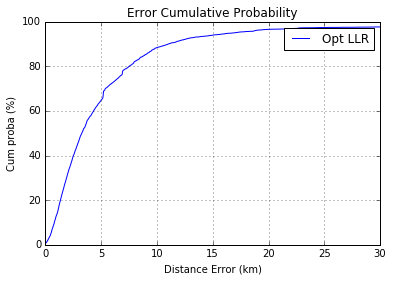

In [149]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [150]:
# Error criterion

np.percentile(err_vec, 80)

7522.0667120795024

In [151]:
# Construct test prediction